## Developing Hierarchical BToM  
This notebook is used for development of a hierarchical BToM model. Unlike BToM, this model learns a categorical distribution over the agent's long term goals.

Steps:

1. Load data
2. Create new BToM instance with hierarchical component
4. Run model on data
5. Save as scripts

In [1]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import json

In [2]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [3]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.agents.agent_species import ShortestPathAgent
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color

## Step 1: Loading the Data

In [4]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #36
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_36_20250507_105353
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges


In [5]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [6]:
import pickle
# if you used dill, just replace pickle with dill

with open('agents.pkl', 'rb') as f:
    agents = pickle.load(f)

In [7]:
with open("./data/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/goal_data.json", 'r') as file:
    goal_data = json.load(file)

In [8]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [9]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 2: Adjust BToM 

In [39]:
import numpy as np
import networkx as nx

class Extended_BToM:
    def __init__(self, campus, agents, goals, beta=1.0):
        """
        Initializes the BToM model.
        
        Parameters:
        -----------
        campus : object
            Contains the NetworkX graph (campus.G).
        agents : list
            List of agent objects (each with attributes 'id', 'path', and 'goal_node').
        beta : float, optional
            Inverse temperature parameter for the softmax.
        """
        self.campus = campus
        self.beta = beta
        self.agents = agents
        
        print("Computing shortest paths...")
        self.all_shortest_paths = dict(nx.all_pairs_shortest_path_length(campus.G_undirected))
        print("Done")
        
        # Candidate goals are derived from the agents' goal nodes; duplicates assumed not to occur.
        self.candidate_goals = goals
        prior_prob = 1 / len(self.candidate_goals)
        self.uniform_prior = {g: prior_prob for g in self.candidate_goals}
        
        self.set_posteriors()

        # Keep track of goals reached for each agent
        self.agent_goal_counts = {agent.id: np.ones(len(self.candidate_goals)) for agent in self.agents}

    def set_posteriors(self):
        # Initialize posterior for each agent
        self.agent_posteriors = {agent.id: self.uniform_prior.copy() for agent in self.agents}

    def agent_goal_distribution(self, agent):
        probs = self.agent_goal_counts[agent.id] / np.sum(self.agent_goal_counts[agent.id])
        return {self.candidate_goals[i]: probs[i] for i in range(len(probs))}

    def update_goal_counts(self, agent, observed_goal):
        goal_idx = self.candidate_goals.index(observed_goal)
        self.agent_goal_counts[agent.id][goal_idx] += 1
        

    def Q_value(self, s, a, g):
        """
        Computes the Q-value for transitioning from state s to state a given goal g.
        Since transitions are deterministic, this is defined as the negative shortest
        path distance from node a to goal g.
        """
        return -self.all_shortest_paths[a][g]

    def update_posterior_step(self, current_posterior, s, a):
        """
        Updates the current posterior over candidate goals based on one state-action pair.
        
        Parameters:
        -----------
        current_posterior : dict
            The current posterior over candidate goals.
        s : node
            The current state (node ID).
        a : node
            The action taken (next node).
        
        Returns:
        --------
        new_posterior : dict
            The updated posterior.
        """
        new_posterior = {}
        # For each candidate goal, update the probability based on the observed action.
        for g in self.candidate_goals:
            prob = current_posterior[g]
            actions_possible = list(self.campus.G.neighbors(s))
            if a not in actions_possible:
                action_prob = 0.0
            else:
                # Compute Q-values and likelihoods for possible actions
                q_vals = np.array([self.Q_value(s, a_prime, g) for a_prime in actions_possible])
                likelihoods = np.exp(self.beta * q_vals)
                likelihoods /= likelihoods.sum()
                action_prob = likelihoods[actions_possible.index(a)]
            new_posterior[g] = prob * action_prob
        
        # Normalize the new posterior
        total = sum(new_posterior.values())
        if total > 0:
            for g in new_posterior:
                new_posterior[g] /= total
        else:
            # Fallback to uniform if total probability is zero
            new_posterior = {g: 1 / len(self.candidate_goals) for g in self.candidate_goals}
        return new_posterior

    def update_agent_posterior_over_path(self, agent, path):
        """
        Updates and returns the list of posterior distributions over candidate goals for each step 
        along the agent's path.
        
        Parameters:
        -----------
        agent : object
            An agent with attributes 'id' and 'path' (a list of node IDs).
        
        Returns:
        --------
        posterior_list : list of dicts
            A list where each element is the posterior distribution (dict) at that step.
        """
        #path = agent.path
        posterior_list = []
        
        # Initialize with the agent's goal distribution
        current_posterior = self.agent_goal_distribution(agent)
        posterior_list.append(current_posterior)
        
        # Loop over each step along the trajectory
        for i in range(len(path)-1):
            s = path[i]
            a = path[i+1]
            current_posterior = self.update_posterior_step(current_posterior, s, a)
            posterior_list.append(current_posterior)
            
        # Optionally, update the stored posterior for the agent with the last posterior
        self.agent_posteriors[agent.id] = current_posterior

        # Update the agents goal distribution using the final node in path
        obs_goal = path[-1]
        self.update_goal_counts(agent, obs_goal)
        
        return posterior_list

    def infer_goal(self, agent):
        """
        Infers the most likely goal for an agent based on its entire observed trajectory.
        
        Parameters:
        -----------
        agent : object
            An agent with attributes 'id' and 'path'.
        
        Returns:
        --------
        inferred_goal : 
            The candidate goal with the highest posterior probability at the final step.
        """
        posterior_list = self.update_agent_posterior_over_path(agent)
        final_posterior = posterior_list[-1]
        inferred_goal = max(final_posterior, key=final_posterior.get)
        return inferred_goal

## Step 3: Run Model

In [29]:
hbtom = HBToM(campus, agents, goals)

Computing shortest paths...
Done


In [30]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        posteriors_data[episode][agent.id] = hbtom.update_agent_posterior_over_path(agent, path_data[episode][agent.id])



## Step 5: Visualize Results

In [35]:
def brier_score(true_goal, p_dist):
    """
    Multi-class Brier score given a dict goal→prob.
    """
    score = 0.0
    for g, p in p_dist.items():
        y = 1.0 if g == true_goal else 0.0
        score += (p - y) ** 2
    return float(score)


def brier_along_path(path, true_goal, posteriors_by_step, goals):
    """
    Compute Brier scores at 0%, 10%, …, 100% of the path.
    
    Parameters
    ----------
    path : list
        The sequence of states (or state-action tuples).
    true_goal : hashable
        The ground-truth goal for this trajectory.
    posteriors_by_step : dict[int, dict] or list[dict]
        Either
          * a dict mapping step index 1..n → posterior dict, OR
          * a list of posterior dicts in step-order (len = n).
        Each posterior dict maps each goal → P(goal | trajectory up to that step).
    
    Returns
    -------
    dict[float, float]
        Mapping fraction → Brier score.
    """
    n = len(path) - 1
    if n < 1:
        raise ValueError("Path must have at least 2 states to define transitions")

    # uniform prior for t=0
    uniform = {g: 1.0/len(goals) for g in goals}

    results = []
    for frac in np.linspace(0, 1, 11):  # 0.0,0.1,...,1.0
        t = int(np.floor(frac * n))
        if t == 0:
            p_dist = uniform
        else:
            p_dist = posteriors_by_step[t-1]
        results.append(brier_score(true_goal, p_dist))

    return results

In [36]:
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))


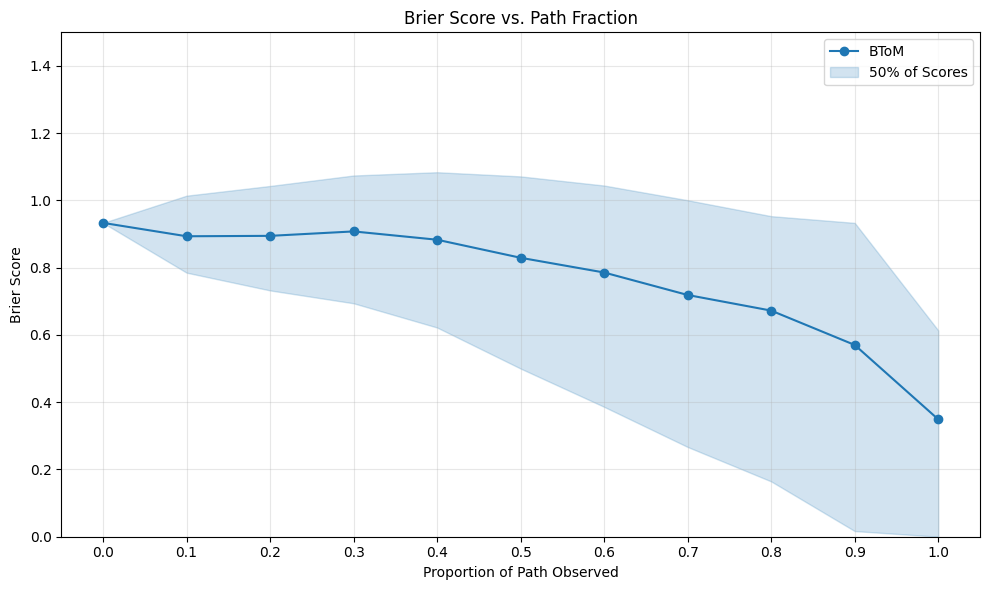

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_scores = arr.mean(axis=0)

# Compute percentiles for a 95% *prediction* interval
lower = np.percentile(arr, 25, axis=0)
upper = np.percentile(arr, 75, axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_scores, '-o', label='BToM')
plt.fill_between(props, lower, upper,
                 color='C0', alpha=0.2,
                 label='50% of Scores')
plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()